In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import os
import statsmodels.formula.api as smf
import sklearn.decomposition as skd
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [6]:
df = pd.read_csv("Data.csv", index_col="TimeStamp")
df.head()

,CloseBTC,CloseETH,Difficulty,MinerRevenue,TotalHashRate,TotalMarketValue,TradeCountBTC,TradeCountETH,TradeVolumeBTC,TradeVolumeETH,TransactionFee,Transactions,UniqueAddress
TimeStamp,,,,,,,,,,,,,
2018-11-11,6449.81,212.54,7.184405e+12,1.166074e+07,4.612191e+07,1.102939e+11,98435,66072,8213.507117,136268.81156,89656.272251,246991.0,422963.0
2018-11-12,6453.07,212.89,7.184405e+12,1.140461e+07,4.724435e+07,1.101502e+11,123144,52826,10132.782567,99963.97203,89656.272251,300006.0,510342.0
2018-11-13,6457.66,209.84,7.184405e+12,9.557212e+06,4.709129e+07,1.090161e+11,150940,65826,11790.564933,114466.36708,89656.272251,279160.0,491741.0
2018-11-14,5922.41,187.43,7.184405e+12,1.048610e+07,4.668313e+07,1.076257e+11,319011,187653,46478.964003,434676.16832,157433.389744,292755.0,524970.0
2018-11-15,5753.40,184.35,7.184405e+12,8.932985e+06,4.693823e+07,9.681672e+10,303825,212442,47700.829401,452416.10784,157433.389744,291525.0,523899.0


### Q1 Production Time and Average Transaction Fee

In [7]:
def Q1():
    data = df.reset_index()
    data["ProductionTime"] = (1 << 32)* data["Difficulty"] / data["TotalHashRate"] / 1e12 
    data["mean"] = data["ProductionTime"].mean()
    data["upper"] = data["mean"] + 2 * data["ProductionTime"].std()
    data["lower"] = data["mean"] - 2 * data["ProductionTime"].std()
    data["minutes"] = data["ProductionTime"] / 60
    data["mean_minutes"] = data["minutes"].mean()
    data["AverageTransactionFee"] = data["TransactionFee"] / data["Transactions"]
    transaction_df = data[["TimeStamp", "AverageTransactionFee"]].copy()
    transaction_df["dow"] = pd.to_datetime(df.index).dayofweek
    model = smf.ols(data=transaction_df, formula="AverageTransactionFee ~ C(dow)").fit()
    transaction_df["AverageTransactionFee_ds"] = model.resid + transaction_df["AverageTransactionFee"].mean()
    transaction_df = transaction_df.melt(id_vars="TimeStamp", value_vars=["AverageTransactionFee", "AverageTransactionFee_ds"])

    line = alt.Chart(data, width=750).mark_line().encode(
        x=alt.X("TimeStamp:T"),
        y=alt.Y("ProductionTime:Q", scale=alt.Scale(domain=[400, 1e3])),
    )
    nearest = alt.selection(type='single', nearest=True, on='mouseover',fields=['TimeStamp'], empty='none')

    selectors = alt.Chart(data).mark_point().encode(
        x='TimeStamp:T',
        opacity=alt.value(0),
        tooltip=["TimeStamp:T", alt.Text("ProductionTime:Q", format=".2f")]
    ).add_selection(
        nearest
    )

    points = line.mark_circle(color="red").encode(
        x='TimeStamp:T',
        opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
    )

    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'ProductionTime:Q', alt.value(' '), format=".2f")
    )

    line_rules = alt.Chart(data).mark_rule(color='gray').encode(
        x='TimeStamp:T',
    ).transform_filter(
        nearest
    )

    mean = alt.Chart(data).mark_line(color="red").encode(
        x=alt.X("TimeStamp:T"),
        y=alt.Y("mean:Q"),
    ) 
    band = alt.Chart(data).mark_area(
        opacity=0.25, color='gray'
    ).encode(
        x=alt.X("TimeStamp:T"),
        y=alt.Y("upper:Q"),
        y2=alt.Y2("lower:Q")
    )
    distribution = alt.Chart(data, width=750).mark_bar().encode(
        x=alt.X("minutes:Q", bin=alt.BinParams(step=0.25)),
        y=alt.Y("count():Q", scale=alt.Scale(domain=[0, 300])),
    )
    rule=alt.Chart(data).mark_rule(color="red").encode(
        x=alt.X("mean_minutes:Q"),
        size=alt.value(2.5),
    )
    text_rule = alt.Chart(data).mark_text(dy=-5).encode(
        x=alt.X("minutes:Q", bin=alt.BinParams(step=0.25), title="Minutes to take to mine a block"),
        y=alt.Y("count():Q"),
        text=alt.Text("count(*):Q")
    )
    chart1 = (line + points + line_rules + text + selectors + mean + band).interactive(bind_y=False)
    chart2 = distribution + rule + text_rule
    
    chart3 = alt.Chart(transaction_df, width=750).mark_line().encode(
        x=alt.X("TimeStamp:T"),
        y=alt.Y("value:Q"),
        color=alt.Color("variable:N"),
        tooltip=["TimeStamp:T", "value:Q", "variable:N"]
    ).interactive(bind_y=False)
    print(data["ProductionTime"].describe())
    print((data["TransactionFee"] / data["Transactions"]).describe())
    return chart1 & chart2 & chart3
Q1()

count    1087.000000
mean      599.964520
std        49.394829
min       496.959737
25%       573.814042
50%       593.523062
75%       610.797291
max       977.059774
Name: ProductionTime, dtype: float64
count    1087.000000
mean        4.662392
std         7.523872
min         0.142745
25%         0.694422
50%         2.009065
75%         4.485168
max        74.785380
dtype: float64


alt.VConcatChart(...)

### Q2 Users, Transactions and Miners

In [8]:
def Q2():
    data = df[["CloseBTC", "MinerRevenue", "UniqueAddress", "Transactions", "TransactionFee", "TotalHashRate"]].copy()
    data["AverageTransactionFee"] = data["TransactionFee"] / data["Transactions"]
    data["HashRevenue"] = data["MinerRevenue"] / data["TotalHashRate"]
    del data["TransactionFee"], data["TotalHashRate"]
    corr = data.corr().reset_index().melt(
        id_vars=["index"], 
        value_vars=["CloseBTC", "MinerRevenue", "UniqueAddress", "Transactions", "AverageTransactionFee", "HashRevenue"],
        value_name="coeff"
    ).rename(columns={"index": "field1", "variable":"field2"})
    base = alt.Chart(corr, width=250, height=250).encode(
        x=alt.X("field1:N"),
        y=alt.Y("field2:N"),
        tooltip=["field1:N", "field2:N", alt.Text("coeff:Q", format=".2f")]
    )
    chart = base.mark_rect().encode(
        color=alt.Color("coeff:Q", scale=alt.Scale(scheme="goldred"))
    )
    text = base.mark_text(baseline='middle', color="white", size=15).encode(
        text=alt.Text("coeff:Q", format=".2f")
    )
    heatmap = chart + text
    diff_data = data.copy()
    for column in data.columns:
        data[column] = data[column].rolling(window=7).mean()
        data[column] = (data[column] - data[column].mean()) / data[column].std()
    data = data.reset_index().melt(id_vars=["TimeStamp"])
    line_chart = alt.Chart(data, width=700).mark_line().encode(
        x=alt.X("TimeStamp:T"),
        y=alt.Y("value:Q"),
        color=alt.Color("variable:N"),
        tooltip=["TimeStamp:T", alt.Text("value:Q", format=".2f"), "variable:N"]
    ).interactive(bind_y=False)
    
    for column in diff_data.columns:
        diff_data[column] = diff_data[column] / diff_data[column].shift(1)
    corr_diff = diff_data.corr().reset_index().melt(
        id_vars=["index"], 
        value_vars=["CloseBTC", "MinerRevenue", "UniqueAddress", "Transactions", "AverageTransactionFee", "HashRevenue"],
        value_name="coeff"
    ).rename(columns={"index": "field1", "variable":"field2"})
    base_diff = alt.Chart(corr_diff, width=250, height=250).encode(
        x=alt.X("field1:N"),
        y=alt.Y("field2:N"),
        tooltip=["field1:N", "field2:N", alt.Text("coeff:Q", format=".2f")]
    )
    chart_diff = base_diff.mark_rect().encode(
        color=alt.Color("coeff:Q", scale=alt.Scale(scheme="goldred"))
    )
    text_diff = base_diff.mark_text(baseline='middle', color="white", size=15).encode(
        text=alt.Text("coeff:Q", format=".2f")
    )
    heatmap_diff = chart_diff + text_diff
    return line_chart
    return (heatmap | heatmap_diff) & line_chart
Q2()

alt.Chart(...)

### Q3 Make Profit

/home/panda/anaconda3/envs/SI618/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


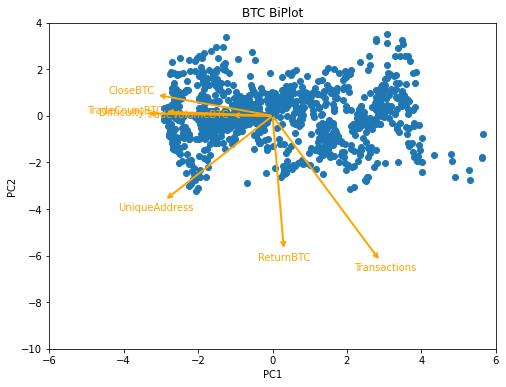

alt.Chart(...)

In [9]:
def Q3():
    BTC_df = df[["CloseBTC", "TradeCountBTC", "TradeVolumeBTC", "Transactions", "Difficulty", "UniqueAddress"]].copy()
    ETH_df = df[["CloseETH", "TradeCountETH", "TradeVolumeETH"]].copy()
    BTC_df["ReturnBTC"] = BTC_df["CloseBTC"].shift(-1) / BTC_df["CloseBTC"]
    ETH_df["ReturnETH"] = ETH_df["CloseETH"].shift(-1) / ETH_df["CloseETH"]
    def PCA():
        BTC_PCA_df = BTC_df.copy()
        for column in BTC_PCA_df.columns:
            BTC_PCA_df[column] = BTC_PCA_df[column].rolling(window=7).mean()
        BTC_PCA_df = BTC_PCA_df.dropna()
        for column in BTC_PCA_df.columns:
            BTC_PCA_df[column] = max(BTC_PCA_df[column]) - BTC_PCA_df[column]
            BTC_PCA_df[column] = (BTC_PCA_df[column] - BTC_PCA_df[column].mean()) / BTC_PCA_df[column].std()
        
        pca_model = skd.PCA().fit(BTC_PCA_df)
        X = pca_model.transform(BTC_PCA_df)
        plt.figure(figsize=(8,6))
        plt.scatter(X[:,0], X[:,1])
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('BTC BiPlot')
        plt.xlim(-6, 6)
        plt.ylim(-10, 4)
        # Add variable unit vector projections
        V = pca_model.transform(np.identity(X.shape[1]))
        for i, v in enumerate(V):
            plt.annotate(BTC_df.columns[i], 
                         xy=(0,0), xytext=v[:2]*10, 
                         fontsize=10, color='orange',
                         arrowprops=dict(
                            arrowstyle='<-', linewidth=2, color='orange'))
        plt.savefig("./BTCBiPlot.png")
        return plt.show()
    PCA()
    invest = pd.DataFrame(columns=["Cash","ETH", "BTC"])
    ETH, BTC = 0, 0
    Cash = 156
    for i in range(0, len(BTC_df), 7):
        Cash -= 1
        ETH += 1 / ETH_df.iloc[i]["CloseETH"]
        BTC += 1 / BTC_df.iloc[i]["CloseBTC"]
        invest.loc[BTC_df.iloc[i].name] = [Cash, ETH, BTC]
    invest["InvestETH"], invest["InvestBTC"] = ETH_df["CloseETH"], BTC_df["CloseBTC"]
    invest["StrategyETH"] = invest["Cash"] + invest["ETH"] * invest["InvestETH"]
    invest["StrategyBTC"] = invest["Cash"] + invest["BTC"] * invest["InvestBTC"]
    invest["StrategyETH"] = invest["StrategyETH"] / 156 
    invest["StrategyBTC"] = invest["StrategyBTC"] / 156 
    invest["InvestETH"] = invest["InvestETH"] / invest["InvestETH"].iloc[0] 
    invest["InvestBTC"] = invest["InvestBTC"] / invest["InvestBTC"].iloc[0]
    invest["InvestHash"] = (df["MinerRevenue"] / df["TotalHashRate"]).cumsum() * 13.5 / 800 + 1
    data = invest[["InvestETH", "InvestBTC", "StrategyETH", "StrategyBTC", "InvestHash"]].reset_index().rename(columns={"index":"TimeStamp"}).melt(id_vars=["TimeStamp"])
    chart = alt.Chart(data, width=750).mark_line().encode(
        x=alt.X("TimeStamp:T"),
        y=alt.Y("value:Q"),
        color=alt.Color("variable:N"),
        tooltip=["TimeStamp:T", alt.Text("value:Q", format=".2f"), "variable:N"]
    )
    return chart.interactive(bind_y=False)

Q3()